In [4]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip
!unzip crawl-300d-2M-subword.zip

--2020-05-24 07:55:20--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 2606:4700:10::6816:4b8e, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5828358084 (5.4G) [application/zip]
Saving to: ‘crawl-300d-2M-subword.zip’

100%[====================================>] 5,828,358,084 13.4MB/s   in 7m 9s  

2020-05-24 08:02:30 (12.9 MB/s) - ‘crawl-300d-2M-subword.zip’ saved [5828358084/5828358084]

Archive:  crawl-300d-2M-subword.zip
  inflating: crawl-300d-2M-subword.vec  
  inflating: crawl-300d-2M-subword.bin  


In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath(''))

In [2]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook
from facebook_hateful_memes_detector.models import FasttextPooledModel
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, StratifiedSampler, my_collate, get_datasets, get_basic_image_transforms
from facebook_hateful_memes_detector.training import *



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
preprocess = get_basic_image_transforms()

In [5]:
data = get_datasets(data_dir="../data/", train_text_transform=None, train_image_transform=preprocess, 
                 test_text_transform=None, test_image_transform=preprocess, 
                 cache_images = True, use_images = True, dev=True)

https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

In [6]:
model_fn = model_builder(FasttextPooledModel, dict(in_dims=500, hidden_dims=1024, num_classes=2,fasttext_file="crawl-300d-2M-subword.bin"),
                         optimiser_class=torch.optim.Adam, optimiser_params=dict(lr=0.001, weight_decay=1e-5))


In [8]:
n_tests = 5
batch_size=128
epochs = 5
train_validate_ntimes(model_fn, data, n_tests, batch_size, epochs)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

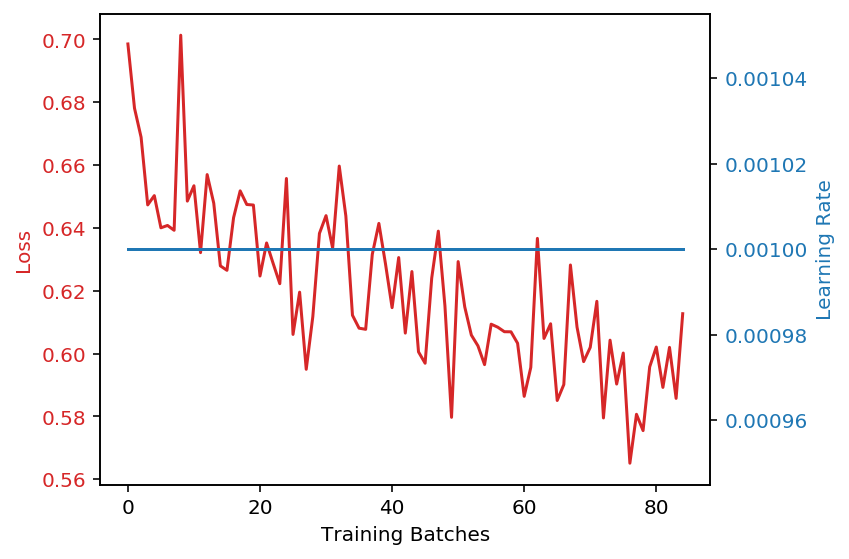

In [13]:
submission = train_and_predict(model_fn, data, batch_size, epochs)
submission.to_csv("submission.csv",index=False)

In [ ]:
submission.head()